#  Classification: premier modèle avec les SVM



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/2_SVM.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/2_SVM.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/2_SVM.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmodelisation%202_SVM%C2%BB&security.allowlist.enabled=false)
<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=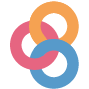)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/modelisation/2_SVM.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/2_SVM.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/modelisation/2_SVM.ipynb)

Pour illustrer le travail d'exploration des données nécessaire avant de construire un modèle de Machine Learning, nous allons partir du même jeu de données que précédemment,
c'est-à-dire les résultats des élections US 2020 présentés dans l'[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles US
croisées à des variables socio-démographiques.
Le code 
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).

<!-- KA : ci-dessous, le code est en echo=TRUE mais n'apparaît bizarrement pas sur le site web ? Comment le faire apparaître ? Enlever le include = FALSE ? -->


In [ ]:
#!pip install geopandas

import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

```
## 3585
```

In [ ]:
import getdata
votes = getdata.create_votes_dataframes()

```
## Error in py_call_impl(callable, dots$args, dots$keywords): AttributeError: module 'getdata' has no attribute 'create_votes_dataframes'
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```





In [ ]:
import matplotlib.pyplot as plt

## La méthode des SVM (Support Vector Machines)

L'une des méthodes de *Machine Learning* les plus utilisées en classification est les SVM. Il s'agit de trouver, dans un système de projection adéquat (noyau ou *kernel*), les paramètres de l'hyperplan (en fait d'un hyperplan à marges maximales) séparant les classes de données: 

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png)

On peut, sans perdre de généralité, supposer que le problème consiste à supposer l'existence d'une loi de probabilité $\mathbb{P}(x,y)$ ($\mathbb{P} \to \{-1,1\}$) qui est inconnue. Le problème de discrimination
vise à construire un estimateur de la fonction de décision idéale qui minimise la probabilité d'erreur, autrement dit $\theta = \arg\min_\Theta \mathbb{P}(h_\theta(X) \neq y |x)$

Les SVM les plus simples sont les SVM linéaires. Dans ce cas, on suppose qu'il existe un séparateur linéaire qui permet d'associer chaque classe à son signe:

$$
h_\theta(x) = \text{signe}(f_\theta(x)) ; \text{ avec } f_\theta(x) = \theta^T x + b
$$
avec $\theta \in \mathbb{R}^p$ et $w \in \mathbb{R}$. 

![](https://en.wikipedia.org/wiki/File:SVM_margin.png)

Lorsque des observations sont linéairement séparables, il existe une infinité de frontières de décision linéaire séparant les deux classes. Le "meilleur" choix est de prendre la marge maximale permettant de séparer les données. La distance entre les deux marges est $\frac{2}{||\theta||}$. Donc maximiser cette distance entre deux hyperplans revient à minimiser $||\theta||^2$ sous la contrainte $y_i(\theta^Tx_i + b) \geq 1$. 

Dans le cas non linéairement séparable, la *hinge loss* $\max\big(0,y_i(\theta^Tx_i + b)\big)$ permet de linéariser la fonction de perte:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Hinge_loss_vs_zero_one_loss.svg/1024px-Hinge_loss_vs_zero_one_loss.svg.png)

ce qui donne le programme d'optimisation suivant:

$$
\frac{1}{n} \sum_{i=1}^n \max\big(0,y_i(\theta^Tx_i + b)\big) + \lambda ||\theta||^2
$$

La généralisation au cas non linéaire implique d'introduire des noyaux transformant l'espace de coordonnées des observations.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Kernel_Machine.svg/1920px-Kernel_Machine.svg.png)


## Exercice

**Exercice 1 : Premier algorithme de classification**


In [ ]:
# packages utiles
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

1. Créer une variable *dummy* appelée `y` dont la valeur vaut 1 quand les républicains l'emportent. 



In [ ]:
# 1. Création de la dummy y de victoire des républicains
votes['y'] = (votes['votes_gop'] > votes['votes_dem']).astype(int)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'votes' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

2. En utilisant la fonction prête à l'emploi nommée `train_test_split` de la librairie `sklearn.model_selection`,
créer des échantillons de test (20 % des observations) et d'estimation (80 %) avec comme *features*: `'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"` et comme *label* la variable `y`. 

> A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

*Note : Pour éviter ce warning à chaque fois que vous estimez votre modèle, vous pouvez utiliser `DataFrame[['y']].values.ravel()` plutôt que `DataFrame[['y']]` lorsque vous constituez vos échantillons.*



In [ ]:
#2. Création des échantillons d'entraînement et de validation
xvars = ['Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"]

df = votes[["y"] + xvars]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'votes' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[xvars],
    df[['y']].values.ravel(), test_size=0.2, random_state=0
)
#X_train.head()
#y_test
     

```
## Error in py_call_impl(callable, dots$args, dots$keywords): KeyError: "None of [Index(['Unemployment_rate_2019', 'Median_Household_Income_2019',\n       'Percent of adults with less than a high school diploma, 2015-19',\n       'Percent of adults with a bachelor's degree or higher, 2015-19'],\n      dtype='object')] are in the [columns]"
## 
## Detailed traceback: 
##   File "<string>", line 2, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/frame.py", line 3511, in __getitem__
##     indexer = self.columns._get_indexer_strict(key, "columns")[1]
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5782, in _get_indexer_strict
##     self._raise_if_missing(keyarr, indexer, axis_name)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5842, in _raise_if_missing
##     raise KeyError(f"None of [{key}] are in the [{axis_name}]")
```

3. Entraîner un classifieur SVM avec comme paramètre de régularisation `C = 1`. Regarder les mesures de performance suivante : `accuracy`, `f1`, `recall` et `precision`.



In [ ]:
# 3. Entraînement du modèle et performances
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: could not convert string to float: 'for the first time during many hours or perhaps days i thought'
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/svm/_base.py", line 190, in fit
##     X, y = self._validate_data(
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_data
##     X, y = check_X_y(X, y, **check_params)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 964, in check_X_y
##     X = check_array(
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 746, in check_array
##     array = np.asarray(array, order=order, dtype=dtype)
```

In [ ]:
y_pred = clf.predict(X_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 425, in predict
##     scores = self.decision_function(X)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 405, in decision_function
##     check_is_fitted(self)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1222, in check_is_fitted
##     raise NotFittedError(msg % {"name": type(estimator).__name__})
```

In [ ]:
sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_pred' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_pred' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_pred' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

#print(sc_accuracy)
#print(sc_f1)
#print(sc_recall)
#print(sc_precision)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_pred' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

Le classifieur avec `C = 1` devrait avoir les performances suivantes:


In [ ]:
out = pd.DataFrame.from_dict({"Accuracy": [sc_accuracy], "Recall": [sc_recall],
                        "Precision": [sc_precision], "F1": [sc_f1]}, orient = "index", columns = ["Score"])

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'sc_accuracy' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print(out.to_markdown())

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'out' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

4. Vérifier la matrice de confusion : vous devriez voir que malgré des scores en apparence pas si mauvais, il y a un problème notable. 



In [ ]:
# 4. Matrice de confusion
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test)

#Réponse : Notre classifieur manque totalement les labels 0, qui sont minoritaires.
#Une raison possible ? L'échelle des variables: le revenu a une
#distribution qui peut écraser celle des autres variables,
#dans un modèle linéaire. Il faut donc, a minima, 
#standardiser les variables.

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py", line 88, in wrapped
##     return fun(*args, **kwargs)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/metrics/_plot/confusion_matrix.py", line 565, in plot_confusion_matrix
##     y_pred = estimator.predict(X)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 425, in predict
##     scores = self.decision_function(X)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 405, in decision_function
##     check_is_fitted(self)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1222, in check_is_fitted
##     raise NotFittedError(msg % {"name": type(estimator).__name__})
```

In [ ]:
plt.savefig("confusion_matrix.png")

```r
knitr::include_graphics("confusion_matrix.png")
```

5. Refaire les questions précédentes avec des variables normalisées. Le résultat est-il différent ?



In [ ]:
# 5. Refaire les questions précédentes avec des variables normalisées.
import sklearn.preprocessing as preprocessing

X = tempdf[xvars]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): KeyError: "None of [Index(['Unemployment_rate_2019', 'Median_Household_Income_2019',\n       'Percent of adults with less than a high school diploma, 2015-19',\n       'Percent of adults with a bachelor's degree or higher, 2015-19'],\n      dtype='object')] are in the [columns]"
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/frame.py", line 3511, in __getitem__
##     indexer = self.columns._get_indexer_strict(key, "columns")[1]
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5782, in _get_indexer_strict
##     self._raise_if_missing(keyarr, indexer, axis_name)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5842, in _raise_if_missing
##     raise KeyError(f"None of [{key}] are in the [{axis_name}]")
```

In [ ]:
y = tempdf[['y']]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): KeyError: "None of [Index(['y'], dtype='object')] are in the [columns]"
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/frame.py", line 3511, in __getitem__
##     indexer = self.columns._get_indexer_strict(key, "columns")[1]
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5782, in _get_indexer_strict
##     self._raise_if_missing(keyarr, indexer, axis_name)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5842, in _raise_if_missing
##     raise KeyError(f"None of [{key}] are in the [{axis_name}]")
```

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y.values.ravel(), test_size=0.2, random_state=0
)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/svm/_base.py", line 190, in fit
##     X, y = self._validate_data(
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_data
##     X, y = check_X_y(X, y, **check_params)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 979, in check_X_y
##     y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 994, in _check_y
##     _assert_all_finite(y)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 114, in _assert_all_finite
##     raise ValueError(
```

In [ ]:
y_pred = clf.predict(X_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 425, in predict
##     scores = self.decision_function(X)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 405, in decision_function
##     check_is_fitted(self)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1222, in check_is_fitted
##     raise NotFittedError(msg % {"name": type(estimator).__name__})
```

In [ ]:
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test)

#Réponse : Non, standardiser les variables n'apporte pas de gain
# Il faut donc aller plus loin : le problème ne vient pas de l'échelle mais du choix des variables. 
# C'est pour cette raison que l'étape de sélection de variable est cruciale.

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py", line 88, in wrapped
##     return fun(*args, **kwargs)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/metrics/_plot/confusion_matrix.py", line 565, in plot_confusion_matrix
##     y_pred = estimator.predict(X)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 425, in predict
##     scores = self.decision_function(X)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 405, in decision_function
##     check_is_fitted(self)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1222, in check_is_fitted
##     raise NotFittedError(msg % {"name": type(estimator).__name__})
```

In [ ]:
plt.savefig("confusion_matrix2.png")

```r
knitr::include_graphics("confusion_matrix2.png")
```


6. Changer de variables *x*. Utiliser uniquement le résultat passé du vote démocrate et le revenu (`votes_gop` et `Median_Household_Income_2019`). Regarder les résultats, notamment la matrice de confusion. 

Le nouveau classifieur avec devrait avoir les performances suivantes :


In [ ]:
out = pd.DataFrame.from_dict({"Accuracy": [sc_accuracy], "Recall": [sc_recall],
                        "Precision": [sc_precision], "F1": [sc_f1]}, orient = "index", columns = ["Score"])

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'sc_accuracy' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
print(out.to_markdown())

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'out' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```





In [ ]:
# 6. Refaire les questions en changeant la variable X.
votes['y'] = (votes['votes_gop'] > votes['votes_dem']).astype(int)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'votes' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
df = votes[["y", "share_2016_republican", 'Median_Household_Income_2019']]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'votes' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
tempdf = df.dropna(how = "any")

X = votes[['share_2016_republican', 'Median_Household_Income_2019']]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'votes' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
y = tempdf[['y']]

```
## Error in py_call_impl(callable, dots$args, dots$keywords): KeyError: "None of [Index(['y'], dtype='object')] are in the [columns]"
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/frame.py", line 3511, in __getitem__
##     indexer = self.columns._get_indexer_strict(key, "columns")[1]
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5782, in _get_indexer_strict
##     self._raise_if_missing(keyarr, indexer, axis_name)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 5842, in _raise_if_missing
##     raise KeyError(f"None of [{key}] are in the [{axis_name}]")
```

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y.values.ravel(), test_size=0.2, random_state=0
)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/svm/_base.py", line 190, in fit
##     X, y = self._validate_data(
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_data
##     X, y = check_X_y(X, y, **check_params)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 979, in check_X_y
##     y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 994, in _check_y
##     _assert_all_finite(y)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 114, in _assert_all_finite
##     raise ValueError(
```

In [ ]:
y_pred = clf.predict(X_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 425, in predict
##     scores = self.decision_function(X)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 405, in decision_function
##     check_is_fitted(self)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1222, in check_is_fitted
##     raise NotFittedError(msg % {"name": type(estimator).__name__})
```

In [ ]:
sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_pred' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_pred' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_pred' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

#print(sc_accuracy)
#print(sc_f1)
#print(sc_recall)
#print(sc_precision)

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NameError: name 'y_pred' is not defined
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
```

In [ ]:
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test)
# On obtient un résultat beaucoup plus cohérent.

```
## Error in py_call_impl(callable, dots$args, dots$keywords): NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
## 
## Detailed traceback: 
##   File "<string>", line 1, in <module>
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py", line 88, in wrapped
##     return fun(*args, **kwargs)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/metrics/_plot/confusion_matrix.py", line 565, in plot_confusion_matrix
##     y_pred = estimator.predict(X)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 425, in predict
##     scores = self.decision_function(X)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 405, in decision_function
##     check_is_fitted(self)
##   File "/opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1222, in check_is_fitted
##     raise NotFittedError(msg % {"name": type(estimator).__name__})
```

In [ ]:
plt.savefig("confusion_matrix3.png")

7. [OPTIONNEL] Faire une 5-fold validation croisée pour déterminer le paramètre *C* idéal. 


In [ ]:
# TODO : correction à rédiger.